In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
import matplotlib
import scipy
import colorsys
import math
import imageio
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave
import PIL
from PIL import Image, ImageFilter
from numpy.fft import fft2, fftshift
import numpy.fft
from scipy.fftpack import fft2, ifft2, fftshift
from ipywidgets import interact, FloatSlider
from IPython.display import display
import matplotlib.colors as mcolors

In [2]:
##preprocess functions for 4DSTEM data from Merlin Detector##

def fix_dead_pixels(data):
    """fix dead pixels for 1 chip data, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)"""
##fix 4 corners##
    if np.sum(data[:,:,0,0]) < 1:
        data[:,:,0,0]=0.5*data[:,:,1,0]+0.5*data[:,:,0,1]
    if np.sum(data[:,:,-1,0]) < 1:
        data[:,:,-1,0]=0.5*data[:,:,-1,1]+0.5*data[:,:,-2,0]
    if np.sum(data[:,:,0,-1]) < 1:
        data[:,:,0,-1]=0.5*data[:,:,1,-1]+0.5*data[:,:,0,-2]
    if np.sum(data[:,:,-1,-1]) < 1:
        data[:,:,-1,-1]=0.5*data[:,:,-2,-1]+0.5*data[:,:,-1,-2]
##fix 4 edges##
    for i in range(data.shape[2]-2):
        if np.sum(data[:,:,i+1,0]) < 1:
            data[:,:,i+1,0] = 0.5*data[:,:,i,0]+0.5*data[:,:,i+2,0]
        if np.sum(data[:,:,i+1,-1]) < 1:
            data[:,:,i+1,-1] = 0.5*data[:,:,i,-1]+0.5*data[:,:,i+2,-1]
    for i in range(data.shape[3]-2):
        if np.sum(data[:,:,0,i+1]) < 1:
            data[:,:,0,i+1] = 0.5*data[:,:,0,i]+0.5*data[:,:,0,i+2]
        if np.sum(data[:,:,-1,i+1]) < 1:
            data[:,:,-1,i+1] = 0.5*data[:,:,-1,i]+0.5*data[:,:,-1,i+2]
##fix center##
    index=np.argwhere(np.sum(data,axis=(0,1))<1)
    for i in index:
        data[:,:,i[0],i[1]]=0.25*data[:,:,i[0]+1,i[1]]+0.25*data[:,:,i[0]-1,i[1]]+0.25*data[:,:,i[0],i[1]+1]+0.25*data[:,:,i[0],i[1]-1]

def fix_dead_pixels_4(data):
    """fix dead pixels for 4 chips data, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)"""
    dx,dy=data[0,0].shape
    index=np.argwhere(np.sum(data,axis=(0,1))<2)
    for i in index: 
        avg=np.zeros(data[:,:,0,0].shape)
        a=0
        if i[0]>0:
            a=a+1
            avg=avg+data[:,:,i[0]-1,i[1]]
        if i[0]<dx-1:
            a=a+1
            avg=avg+data[:,:,i[0]+1,i[1]]
        if i[1]>0:
            a=a+1
            avg=avg+data[:,:,i[0],i[1]-1]
        if i[1]<dy-1:
            a=a+1
            avg=avg+data[:,:,i[0],i[1]+1]
        data[:,:,i[0],i[1]]=np.round(avg/a)
        if np.sum(data[:,:,i[0],i[1]])<2:
            data[:,:,i[0],i[1]]=avg
def fix_cross(data,d_type="uint8"):
    """fix the cross in the middle for Merlin 4 chips data, key in nparray(use "data.data" for py4DSTEM)"""
    ##fix 4 corners##
    data[:,:,255,0]=np.round(0.8*data[:,:,254,0]+0.2*data[:,:,259,0])
    data[:,:,256,0]=np.round(0.6*data[:,:,254,0]+0.4*data[:,:,259,0])
    data[:,:,257,0]=np.round(0.4*data[:,:,254,0]+0.6*data[:,:,259,0])
    data[:,:,258,0]=np.round(0.2*data[:,:,254,0]+0.8*data[:,:,259,0])
    data[:,:,255,513]=np.round(0.8*data[:,:,254,513]+0.2*data[:,:,259,513])
    data[:,:,256,513]=np.round(0.6*data[:,:,254,513]+0.4*data[:,:,259,513])
    data[:,:,257,513]=np.round(0.4*data[:,:,254,513]+0.6*data[:,:,259,513])
    data[:,:,258,513]=np.round(0.2*data[:,:,254,513]+0.8*data[:,:,259,513])
    data[:,:,0,255]=np.round(0.8*data[:,:,0,254]+0.2*data[:,:,0,259])
    data[:,:,0,256]=np.round(0.6*data[:,:,0,254]+0.4*data[:,:,0,259])
    data[:,:,0,257]=np.round(0.4*data[:,:,0,254]+0.6*data[:,:,0,259])
    data[:,:,0,258]=np.round(0.2*data[:,:,0,254]+0.8*data[:,:,0,259])
    data[:,:,513,255]=np.round(0.8*data[:,:,513,254]+0.2*data[:,:,513,259])
    data[:,:,513,256]=np.round(0.6*data[:,:,513,254]+0.4*data[:,:,513,259])
    data[:,:,513,257]=np.round(0.4*data[:,:,513,254]+0.6*data[:,:,513,259])
    data[:,:,513,258]=np.round(0.2*data[:,:,513,254]+0.8*data[:,:,513,259])
    ##fix centre,##
    ##l:(:,:,254,:) r:(:,:,259,:) u:(:,:,:,254) d:(:,:,:,259)##
    data[:,:,255,1:513]=np.round(0.8*data[:,:,254,1:513]+0.2*data[:,:,259,1:513])
    data[:,:,256,1:513]=np.round(0.6*data[:,:,254,1:513]+0.4*data[:,:,259,1:513])
    data[:,:,257,1:513]=np.round(0.4*data[:,:,254,1:513]+0.6*data[:,:,259,1:513])
    data[:,:,258,1:513]=np.round(0.2*data[:,:,254,1:513]+0.8*data[:,:,259,1:513])
    data[:,:,1:513,255]=np.round(0.8*data[:,:,1:513,254]+0.2*data[:,:,1:513,259])
    data[:,:,1:513,256]=np.round(0.6*data[:,:,1:513,254]+0.4*data[:,:,1:513,259])
    data[:,:,1:513,257]=np.round(0.4*data[:,:,1:513,254]+0.6*data[:,:,1:513,259])
    data[:,:,1:513,258]=np.round(0.2*data[:,:,1:513,254]+0.8*data[:,:,1:513,259])
    
def fix_dead_pixel_real(data,x,y):
    """fix weird pixels in real part, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)"""
    data[x,y,:,:]=0.25*data[x-1,y,:,:]+0.25*data[x+1,y,:,:]+0.25*data[x,y-1,:,:]+0.25*data[x,y+1,:,:]

In [3]:
##zncc(calculating Pearson Correlation Coefficient from 2 images)##
def zncc(ref,sig):
    """
    zero normalized cross correlation (zncc)
    calculating the PCC ranging fron (-1,1) of the 2 images
    keywords:
    ref:the reference to compare
    sig:signal
    return: pcc factor
    """
    norm_ref=(ref-np.mean(ref))/np.std(ref)
    norm_signal=(sig-np.mean(sig))/np.std(sig)
    zncc=np.mean(norm_ref*norm_signal)
    return zncc

##do zncc to 4d data##
def generate_pcc_map(data, tem):
    """
    use a real sapce image as a template (e.g. virtual ADF/BF image, could be any image extract from the 4D dataset with the same shape as the scan plane).
    use each pixel in diffraction plane to generate a image and calculate the PCC between the image and the template
    return the pcc map in diffraction plane
    
    keywords:
    data: 4D-dataset, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)
    tem: the template image
    """
    pcc_map=np.zeros((data.shape[2],data.shape[3]))
    norm_tem=(tem-np.mean(tem))/np.std(tem)
    data_mean=np.mean(data,axis=(0,1))
    data_std=np.zeros((data.shape[2], data.shape[3]))
    for i in range(data.shape[2]):
        data_std[i,:]=np.std(data[:,:,i,:],axis=(0,1))
    for i in range(data.shape[2]):
        for j in range(data.shape[3]):
            norm_signal=(data[:,:,i,j]-data_mean[i,j])/data_std[i,j]
            pcc_map[i,j]=np.mean(norm_tem*norm_signal)
    return pcc_map

##create annual/round mask##
def r_mask(shape,r_in,r_out,center=None,ref_img=None,show=True,cmap="inferno"):
    """
    create a round/annular mask
    
    keywords:
    shape: the total shape of the mask (usually use the shape of the diffraction plane)
    r_in: the inner radius of the mask, for round mask use 0
    r_out: the outer radius of the mask
    center: the center of the mask, default in the middle
    ref_img: reference image you want to show the mask, by default show the mask only
    cmap:"inferno" as default. The colormap of the reference image.
    
    return the mask array(2d array)
    """
    if center is None:
        center=(int(shape[0]/2),int(shape[1]/2))
    mask=np.zeros(shape,int)
    for i in range(r_out):
        for j in range(r_out):
            if r_in**2<=i**2+j**2<=r_out**2:
                if center[0]+i<shape[0] and center[1]+j<shape[1]:
                    mask[center[0]+i,center[1]+j]=1
                if center[0]-i>=0 and center[1]+j<shape[1]:
                    mask[center[0]-i,center[1]+j]=1
                if center[0]+i<shape[0] and center[1]-j>=0:
                    mask[center[0]+i,center[1]-j]=1
                if center[0]-i>=0 and center[1]-j>=0:
                    mask[center[0]-i,center[1]-j]=1
    if show is True:
        fig_mask,ax=plt.subplots(1,1,figsize=(4,4))
        ax.set_title("mask")
        ax.axes.set_axis_off()
        if ref_img is None:
            ax.imshow(mask)
        else:
            msk=plt.imshow(mask,alpha=0.25, cmap="gray")
            ax.imshow(ref_img,cmap=cmap,norm=matplotlib.colors.PowerNorm(0.4))
            ax.add_image(msk)
    return mask

##apply a mask on the dataset to generate an image##
def masked_img(data, mask, mode = "mean"):
    """
    apply a mask (or something similar) to the dataset and form an image
    keywords:
    data: 4D-dataset, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)
    mask: the mask you want to apply(2d array)
    mode: "mean" or "sum". The way you want the result to be calculated, by default is "mean"
    
    return image result (masked image)
    """
    img_res=np.zeros((data.shape[0],data.shape[1]))
    if mode == "mean":
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                img_res[i,j]=np.mean(data[i,j,:,:]*mask)
    elif mode == "sum":
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                img_res[i,j]=np.sum(data[i,j,:,:]*mask)
    return img_res

##get information for diffraction plane##
def get_info_dp(data):
    """
    get information for diffraction plane
    keywords:
    data: 4D-dataset, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)
    
    return 3 images(as array): 1. the mean, 2. the standard deviation, 3. the coefficient of variance
    """
    dp_mean=np.mean(data,axis=(0,1))
    dp_std=np.zeros((data.shape[2],data.shape[3]))
    for i in range(data.shape[2]):
        dp_std[i,:]=np.std(data[:,:,i,:],axis=(0,1))
    dp_cv=dp_std/dp_mean
    fig,axs=plt.subplots(1,2,figsize=(10,4))
    axs[0].imshow(dp_mean)
    axs[0].set_title("dp_mean")
    axs[1].imshow(dp_std)
    axs[1].set_title("dp_std")
    return dp_mean,dp_std

##get information for scan plane##
def get_info_sp(data):
    """
    get information for scan plane
    keywords:
    data: 4D-dataset, key in nparray(use "data.data" for py4DSTEM, "data.array" for abtem)
    
    return 2 images(as array): 1. the mean, 2. the standard deviation
    """
    real_mean=np.mean(data,axis=(2,3))
    real_std=np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[0]):
        real_std[i,:]=np.std(data[i,:,:,:],axis=(1,2))
    fig,axs=plt.subplots(1,2,figsize=(10,4))
    axs[0].imshow(real_mean)
    axs[0].set_title("scan_mean")
    axs[1].imshow(real_std)
    axs[1].set_title("scan_std")
    return real_mean,real_std

In [4]:
###create color maps###

colors = ["#1f77b4", "#ffffff", "#FF5F0F"]
blue_or = mcolors.LinearSegmentedColormap.from_list("custom_blue_orange", colors, N=256)
colors_black_green = [(0, 0, 0),(0, 0.3, 0.1),(0.2, 0.7, 0.3),(0.5, 0.95, 0.5)]
c_g = mcolors.LinearSegmentedColormap.from_list('black_to_slightlyyellowgreen', colors_black_green)
colors_black_pink = [(0, 0, 0),(0.5, 0.1, 0.4),(0.9, 0.3, 0.7),(1.0, 0.6, 0.9)]
c_p = mcolors.LinearSegmentedColormap.from_list('black_to_hotpink', colors_black_pink)
colors_black_blue = [(0, 0, 0),(0.1, 0.2, 0.5),(0.4, 0.6, 0.8),(0.7, 0.9, 1.0)]
c_b = mcolors.LinearSegmentedColormap.from_list('black_to_lightblue', colors_black_blue)
colors_black_red = [(0, 0, 0),(0.4, 0.05, 0.05),(0.7, 0.3, 0.3), (0.95, 0.55, 0.55)]
c_r = mcolors.LinearSegmentedColormap.from_list('black_to_mediumred', colors_black_red)

In [5]:
py4DSTEM.__version__

'0.13.17'

In [6]:
roots="F:/20240509 4d/20240509_112656/"
data=np.load(roots+"experiment_LFP.npy")
data=data.astype("float32")

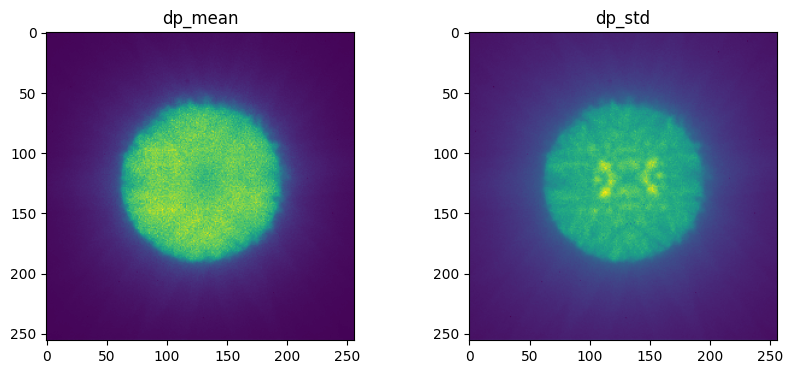

In [7]:
##basic imaging of diffraction plane##
dp_mean,dp_std=get_info_dp(data)

In [8]:
###We apply a gaussian blur for smoothing###
g=scipy.ndimage.gaussian_filter
b_data=np.zeros(data.shape,data.dtype)
for i in range(256):
    for j in range(256):
        b_data[:,:,i,j]=g(data[:,:,i,j],sigma=0.8)

In [9]:
###crop data###
b_data=b_data[8:,0:120]
data=data[8:,0:120]
b_data.shape

(120, 120, 256, 256)

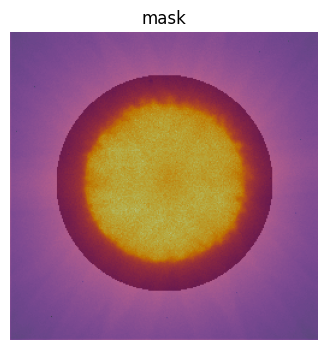

In [10]:
###create ADF mask###
centre=(125,128)
adf_mask=r_mask(dp_mean.shape,90,200,centre,dp_mean)

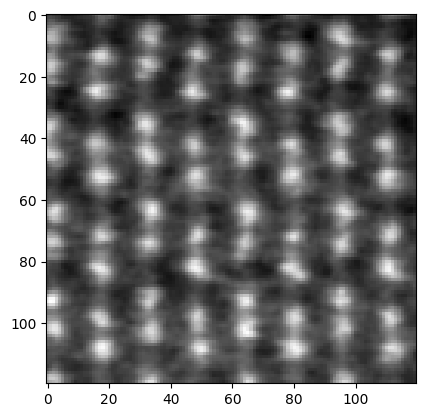

In [11]:
###ADF-STEM###
adf=masked_img(b_data,adf_mask)
plt.imshow(adf,cmap="gray")

In [12]:
###generate the PCC map using ADF as template###
pcc_adf=generate_pcc_map(b_data,adf)

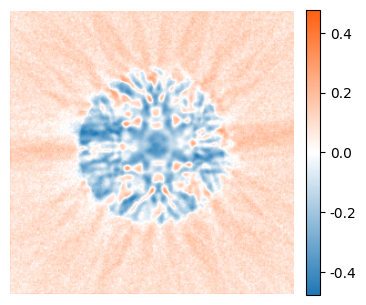

In [13]:
max_value=abs(pcc_adf).max()
a=1
norm = matplotlib.colors.Normalize(vmin=-max_value*a, vmax=max_value*a)
fig,axs=plt.subplots(1,1,figsize=(4,4))
axs.imshow(pcc_adf,cmap=blue_or, vmin=-max_value*a, vmax=max_value*a)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm,cmap=blue_or),
    ax=axs, fraction=0.046, pad=0.04,
    format='%.1f'
)
axs.axes.set_axis_off()

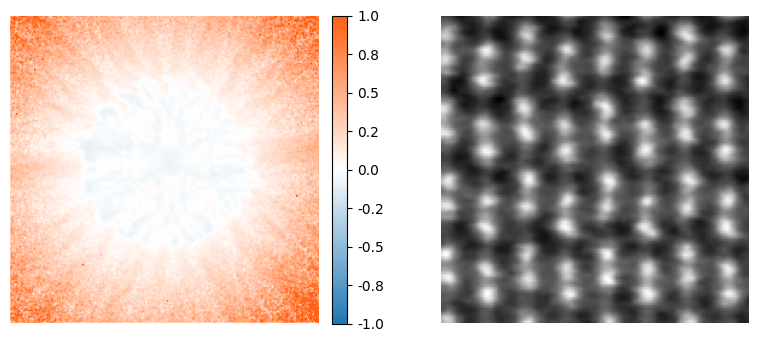

In [14]:
pcc_mask_adf=pcc_adf/dp_mean
a=0.15
pcc_mask_adf=pcc_mask_adf/abs(pcc_mask_adf).max()/a
e_adf=masked_img(b_data,pcc_mask_adf)
max_value=abs(pcc_mask_adf).max()
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
fig,axs=plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(pcc_mask_adf,cmap=blue_or, vmin=-1, vmax=1)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm,cmap=blue_or),
    ax=axs[0], fraction=0.046, pad=0.04,
    format='%.1f'
)
axs[0].axes.set_axis_off()
axs[1].imshow(e_adf,cmap="gray")
axs[1].axes.set_axis_off()

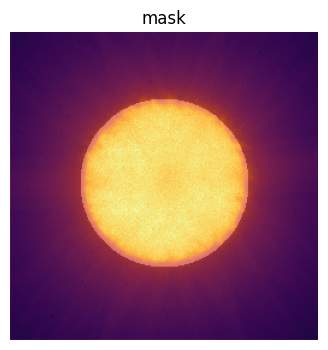

In [15]:
bf_mask=r_mask(dp_mean.shape,0,70,centre,dp_mean)

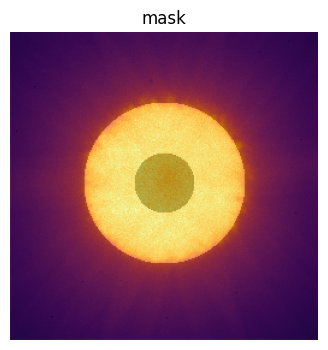

In [16]:
abf_mask=r_mask(dp_mean.shape,25,67,centre,dp_mean)

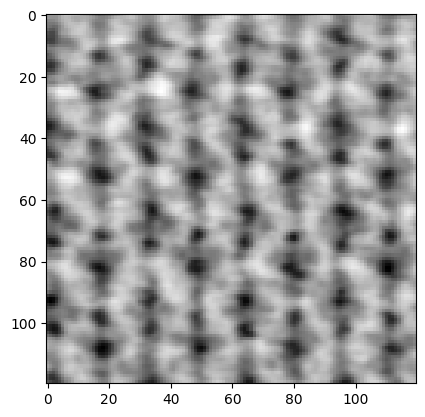

In [17]:
###ABF imaging###
abf=masked_img(b_data,abf_mask)
plt.imshow(abf,cmap="gray")

In [18]:
###generate binary masks for different types of atoms###

points_Fe=[(25,1), (21,17), (24,33), (21,49), (25,63), (21,79), (25,94), (21,111), (25,126),
           (54,1), (50,16), (54,33), (50,48), (54,63), (50,79), (54,94), (50,110), (54,126), 
           (82,1), (79,17), (82,33), (79,49), (82,64), (79,79), (82,95), (79,111), (82,126), 
           (110,2), (107,17), (110,33), (107,49), (110,64), (107,79), (110,95), (107,111), (110,126), 
          ]
array_Fe=np.array(points_Fe)
points_Fe_x = array_Fe[:,1]
points_Fe_y = array_Fe[:,0]

points_P=[(16,1), (32,16), (16,33), (32,47), (15,64), (32,79), (16,95), (32,110), (15,126),
           (44,1), (61,17), (44,32), (61,48), (44,63), (61,79), (44,94), (61,110), (44,126), 
           (72,2), (90,17), (72,33), (90,48), (72,64), (90,79), (72,96), (90,111), (72,126), 
           (100,1), (116,17), (100,33), (116,49), (100,64), (116,80), (100,95), (116,112), (100,126), 
           (127,2),(127,33),(127,65),(127,96),(127,126)
          ]
array_P=np.array(points_P)
points_P_x = array_P[:,1]
points_P_y = array_P[:,0]

points_O1=[(18,8), (18,27), (18,40), (18,59), (18,71), (18,90), (18,102), (18,121),
           (29,9), (29,23), (29,42), (29,53), (29,73), (29,84), (29,105), (29,116), 
           (47,7), (47,26), (47,39), (47,58), (47,69),  (47,90), (47,100), (47,121), 
           (57,12), (57,23), (57,43), (57,54), (57,73), (57,86), (57,105), (57,116), 
           (77,7), (77,27), (77,40), (77,58), (77,71), (77,90), (77,102), (77,122), 
           (87,11), (87,23), (87,42), (87,53), (87,73), (87,84), (87,105), (87,116),            
           (105,8), (105,27), (105,40), (105,59), (105,71),  (105,90), (105,102), (105,121), 
           (115,11), (115,23), (115,42), (115,55), (115,73), (115,87), (115,105), (115,118),            
          ]
array_O1=np.array(points_O1)
points_O1_x = array_O1[:,1]
points_O1_y = array_O1[:,0]
points_O2=[(8,2), (12,16), (8,33), (12,49), (8,64), (12,79), (8,97), (12,110), (8,125),
           (37,1), (41,17), (37,32), (41,48), (36,63), (41,79), (37,94), (41,110), (37,126), 
           (64,1), (68,17), (64,33), (68,48), (64,64), (69,80), (64,96), (68,111), (64,126), 
           (94,1), (98,17), (94,33), (98,49), (94,64), (98,80), (94,95), (98,112), (94,126), 
           (120,1), (124,17), (120,33), (124,49), (120,64), (124,80), (120,95), (124,112), (120,126),      
          ]
array_O2=np.array(points_O2)
points_O2_x = array_O2[:,1]
points_O2_y = array_O2[:,0]

points_Li=[]
for i in range(8):
    Li_x=int(np.round(0.5*points_O2[i][0]+0.5*points_O2[i+1][0]))
    Li_y=int(np.round(0.5*points_O2[i][1]+0.5*points_O2[i+1][1]))
    points_Li.append((Li_x,Li_y))
for i in range(3):
    for j in range(8):
        Li_x=int(np.round(0.25*points_O2[9*i+j+9][0]+0.25*points_O2[9*i+j+10][0]+0.25*points_O1[16*i+8+j][0]+0.25*points_O1[16*i+16+j][0]))
        Li_y=int(np.round(0.25*points_O2[9*i+j+9][1]+0.25*points_O2[9*i+j+10][1]+0.25*points_O1[16*i+8+j][1]+0.25*points_O1[16*i+16+j][1]))
        points_Li.append((Li_x,Li_y))
for i in range(8):
    Li_x=int(np.round(0.5*points_O2[i+36][0]+0.5*points_O2[i+37][0]))
    Li_y=int(np.round(0.5*points_O2[i+36][1]+0.5*points_O2[i+37][1]))
    points_Li.append((Li_x,Li_y))
array_Li=np.array(points_Li)
points_Li_x = array_Li[:,1]
points_Li_y = array_Li[:,0]

template_P=np.zeros((128,127))
template_Fe=np.zeros((128,127))
template_Li=np.zeros((128,127))
template_O=np.zeros((128,127))
for point in points_Fe:
    template_Fe[point]=1
for point in points_P:
    template_P[point]=1
for point in points_Li:
    template_Li[point]=1
for point in points_O1:
    template_O[point]=1
for point in points_O2:
    template_O[point]=1
    
template_all=template_Fe+template_P+template_O+template_Li
template_all=template_all[8:,0:120]
template_Fe=template_Fe[8:,0:120]
template_P=template_P[8:,0:120]
template_O=template_O[8:,0:120]
template_Li=template_Li[8:,0:120]

In [19]:
###Use a corner to calculate the mask for different atom columns###
pcc_all=generate_pcc_map(b_data[8:64,1:65],template_all[8:64,1:65])
pcc_Fe=generate_pcc_map(b_data[8:64,1:65],template_Fe[8:64,1:65])
pcc_P=generate_pcc_map(b_data[8:64,1:65],template_P[8:64,1:65])
pcc_O=generate_pcc_map(b_data[8:64,1:65],template_O[8:64,1:65])
pcc_Li=generate_pcc_map(b_data[8:64,1:65],template_Li[8:64,1:65])
img_all=masked_img(b_data,pcc_all*bf_mask)
img_Fe=masked_img(b_data,pcc_Fe*bf_mask)
img_P=masked_img(b_data,pcc_P*bf_mask)
img_O=masked_img(b_data,pcc_O*bf_mask)
img_Li=masked_img(b_data,pcc_Li*bf_mask)

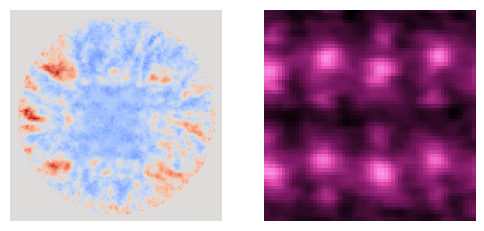

In [20]:
###atom column sensitive images###
max_value=abs(pcc_Fe*bf_mask).max()
fig,axs=plt.subplots(1,2,figsize=(6,3))
axs[0].imshow((pcc_Fe*bf_mask)[centre[0]-75:centre[0]+75,centre[1]-75:centre[1]+75].transpose(),cmap="coolwarm", vmin=-max_value, vmax=max_value)
axs[0].axes.set_axis_off()
axs[1].imshow(img_Fe[0:60,0:60],cmap=c_p)
axs[1].axes.set_axis_off()

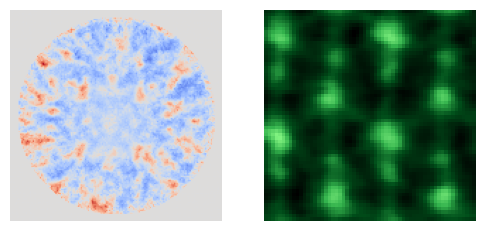

In [21]:
max_value=abs(pcc_P*bf_mask).max()
fig,axs=plt.subplots(1,2,figsize=(6,3))
axs[0].imshow((pcc_P*bf_mask)[centre[0]-75:centre[0]+75,centre[1]-75:centre[1]+75].transpose(),cmap="coolwarm", vmin=-max_value, vmax=max_value)
axs[0].axes.set_axis_off()
axs[1].imshow(img_P[0:60,60:],cmap=c_g)
axs[1].axes.set_axis_off()

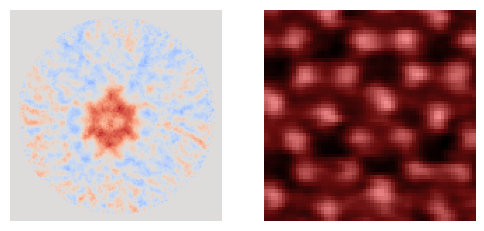

In [22]:
max_value=abs(pcc_O*bf_mask).max()
fig,axs=plt.subplots(1,2,figsize=(6,3))
axs[0].imshow((pcc_O*bf_mask)[centre[0]-75:centre[0]+75,centre[1]-75:centre[1]+75].transpose(),cmap="coolwarm", vmin=-max_value, vmax=max_value)
axs[0].axes.set_axis_off()
axs[1].imshow(img_O[60:,0:60],cmap=c_r)
axs[1].axes.set_axis_off()

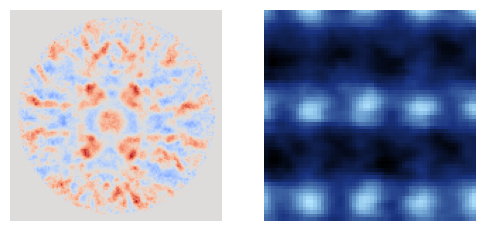

In [23]:
max_value=abs(pcc_Li*bf_mask).max()
fig,axs=plt.subplots(1,2,figsize=(6,3))
axs[0].imshow((pcc_Li*bf_mask)[centre[0]-75:centre[0]+75,centre[1]-75:centre[1]+75].transpose(),cmap="coolwarm", vmin=-max_value, vmax=max_value)
axs[0].axes.set_axis_off()
axs[1].imshow(img_Li[60:,60:],cmap=c_b)
axs[1].axes.set_axis_off()

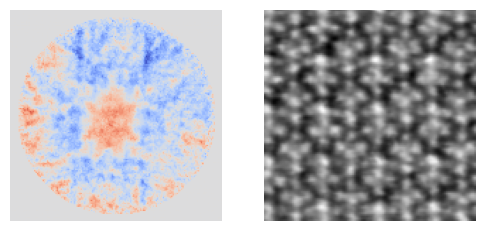

In [24]:
max_value=abs(pcc_all*bf_mask).max()
fig,axs=plt.subplots(1,2,figsize=(6,3))
axs[0].imshow((pcc_all*bf_mask)[centre[0]-75:centre[0]+75,centre[1]-75:centre[1]+75].transpose(),cmap="coolwarm", vmin=-max_value, vmax=max_value)
axs[0].axes.set_axis_off()
axs[1].imshow(img_all,cmap="gray")
axs[1].axes.set_axis_off()